In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import OneHotEncoder
import pickle
warnings.filterwarnings('ignore')

# Data Cleaning 

In [2]:
df=pd.read_csv('laptop_data.csv',index_col=0)
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [3]:
df.shape

(1303, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   object 
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   object 
 10  Price             1303 non-null   float64
dtypes: float64(2), object(9)
memory usage: 122.2+ KB


#### Some columns have mismatched data types like weight and RAM

In [5]:
# checking for missing values
df.isnull().sum()

Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

In [6]:
# checking for duplicate rows
df.duplicated().sum()

29

In [7]:
df.drop_duplicates(inplace=True) # dropping duplicate rows 

In [8]:
# RAM is an integer column, we will delete GB from the ram values and will change it to integer type

df['Ram']=df['Ram'].str.replace('GB','')
df['Ram']=df['Ram'].astype('int64') 

# Weight is a float column, we will delete kg from the weight values and will change it to float type

df['Weight']=df['Weight'].str.replace('kg','')
df['Weight']=df['Weight'].astype('float64')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1274 entries, 0 to 1273
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1274 non-null   object 
 1   TypeName          1274 non-null   object 
 2   Inches            1274 non-null   float64
 3   ScreenResolution  1274 non-null   object 
 4   Cpu               1274 non-null   object 
 5   Ram               1274 non-null   int64  
 6   Memory            1274 non-null   object 
 7   Gpu               1274 non-null   object 
 8   OpSys             1274 non-null   object 
 9   Weight            1274 non-null   float64
 10  Price             1274 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 119.4+ KB


In [10]:
# looking at the screen resolution column
df['ScreenResolution'].value_counts()

ScreenResolution
Full HD 1920x1080                                505
1366x768                                         262
IPS Panel Full HD 1920x1080                      226
IPS Panel Full HD / Touchscreen 1920x1080         51
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160               10
4K Ultra HD 3840x2160                              7
Touchscreen 2560x1440                              7
IPS Panel 1366x768                                 7
IPS Panel Retina Display 2560x1600                 6
IPS Panel Retina Display 2304x1440                 6
Touchscreen 2256x1504                              6
IPS Panel Touchscreen 2560x1440                    5
IPS Panel Quad HD+ / Touchscr

### I can get info about the resolution , whether the screen is touch screen or not, IPS or not etc. But I will have to extract these features.


In [11]:
# Making a Touchscreen column (whether the laptop has touchscreen or not)
df['TouchScreen']=df["ScreenResolution"].map(lambda x : 1 if 'Touchscreen' in x else 0)

# Making an IPS column (whether the laptop has IPS panel or not)
df['Ips']=df["ScreenResolution"].map(lambda x : 1 if 'IPS' in x else 0)


In [12]:
# extracting resolution from screen resolution column
resolution=df['ScreenResolution'].str.split('x')
df['X_Resolution']=resolution.map(lambda x : x[0])
df['Y_Resolution']=resolution.map(lambda x : x[1])

In [13]:
# extracting number from X_Resolution
def x_res(s):
    res=''
    for i in s:     
        if i.isdigit():
            res=res+i
    if len(res)==5:  # in some cases we have '4K' in the s value. to remove that 4 i use this.
        res=res[1:]  # if lenth of resolution is 5 that means an extra 4 from 4K got attached.
    return res
df['X_Resolution']=df['X_Resolution'].map(x_res)

# changing the type of Xresolution and yresolution
df['X_Resolution']=df['X_Resolution'].astype('int64')
df['Y_Resolution']=df['Y_Resolution'].astype('int64')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1274 entries, 0 to 1273
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1274 non-null   object 
 1   TypeName          1274 non-null   object 
 2   Inches            1274 non-null   float64
 3   ScreenResolution  1274 non-null   object 
 4   Cpu               1274 non-null   object 
 5   Ram               1274 non-null   int64  
 6   Memory            1274 non-null   object 
 7   Gpu               1274 non-null   object 
 8   OpSys             1274 non-null   object 
 9   Weight            1274 non-null   float64
 10  Price             1274 non-null   float64
 11  TouchScreen       1274 non-null   int64  
 12  Ips               1274 non-null   int64  
 13  X_Resolution      1274 non-null   int64  
 14  Y_Resolution      1274 non-null   int64  
dtypes: float64(3), int64(5), object(7)
memory usage: 159.2+ KB


# EDA and Feature Engineering

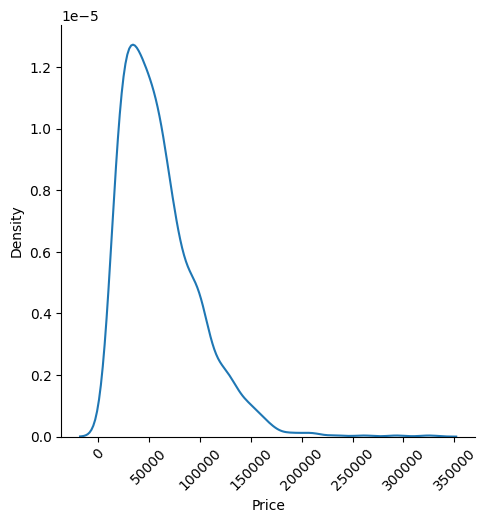

In [15]:
# Distribution of Prices
sns.displot(df['Price'],kind='kde')
plt.xticks(rotation=45);

#### The distribution is a little skewed to the right.

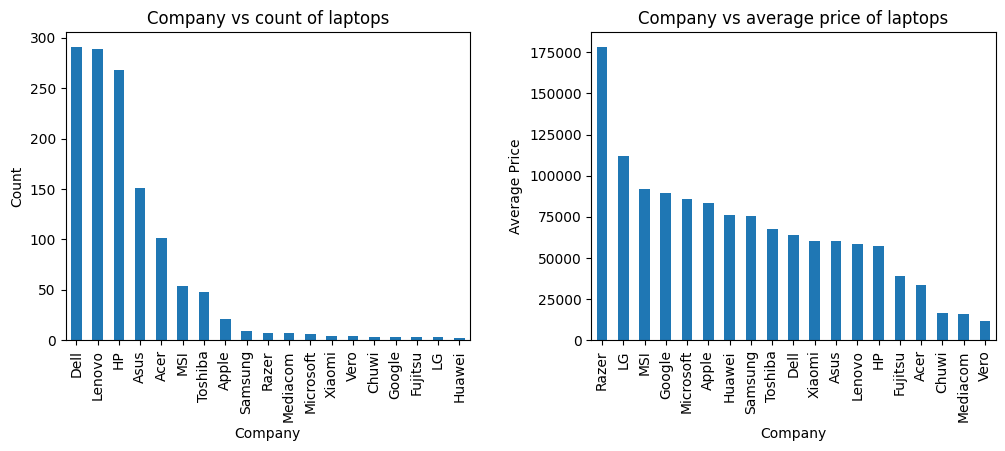

In [16]:
# Looking for number of laptops of each brand

plt.figure(figsize=(12,4)) # defining figure size
plt.subplots_adjust(wspace=0.3) # giving space between plots

#first plot
plt.subplot(1,2,1,title='Company vs count of laptops')
df['Company'].value_counts().plot(kind='bar');
plt.xlabel('Company')
plt.ylabel('Count')

# second plot
plt.subplot(1,2,2,title='Company vs average price of laptops')
df.groupby('Company')["Price"].mean().sort_values(ascending=False).plot(kind='bar'); # average price for each brand
plt.xlabel('Company')
plt.ylabel('Average Price');

### 1. Dell, Lenovo, HP, ASUS etc. have the most number of laptops 
### 2. These brands on average have budget friendly or economic laptops
### 3. Razor has the most expensive laptops
### 4. Company name will be a good predictor of price in the final model.

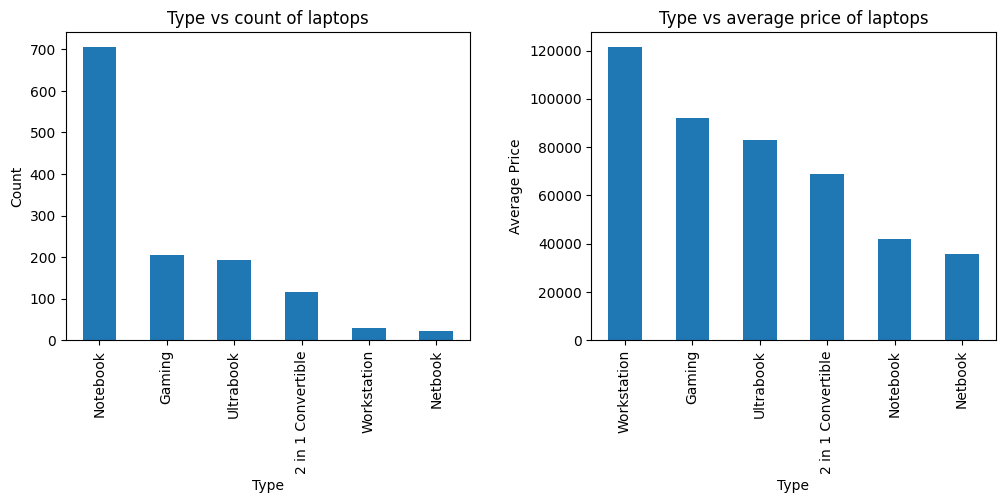

In [17]:
# Looking for number of laptops of each type

plt.figure(figsize=(12,4)) # defining figure size
plt.subplots_adjust(wspace=0.3) # giving space between plots

#first plot
plt.subplot(1,2,1,title='Type vs count of laptops')
df['TypeName'].value_counts().plot(kind='bar');
plt.xlabel('Type')
plt.ylabel('Count')

# second plot
plt.subplot(1,2,2,title='Type vs average price of laptops')
df.groupby('TypeName')["Price"].mean().sort_values(ascending=False).plot(kind='bar'); # average price for each brand
plt.xlabel('Type')
plt.ylabel('Average Price');

### 1. Most of the laptops are Notebooks.
### 2. Notebooks are the cheapest on an average.
### 3. Workstaions are the most expensive.
### 4. Type of laptop will be a good predictor of price.

Text(0, 0.5, 'Average Price')

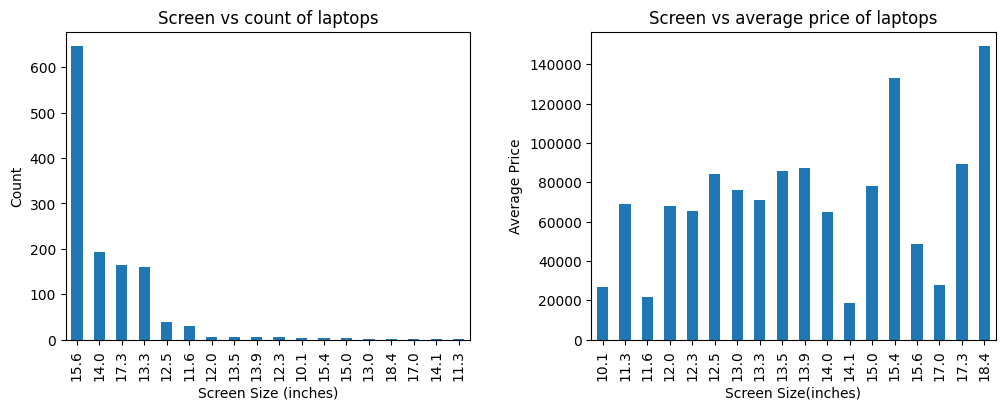

In [18]:
plt.figure(figsize=(12,4)) # defining figure size
plt.subplots_adjust(wspace=0.3) # giving space between plots

# Number of Laptops of different sizes
plt.subplot(1,2,1,title='Screen vs count of laptops')
df['Inches'].value_counts().plot(kind='bar')
plt.xlabel('Screen Size (inches)')
plt.ylabel('Count')

# average price of laptops of different sizes
plt.subplot(1,2,2,title='Screen vs average price of laptops')
df.groupby('Inches')['Price'].mean().plot(kind='bar')
plt.xlabel('Screen Size(inches)')
plt.ylabel('Average Price')

### Most laptops are between 12-16 inches.
### Price is not linearly changing with screen size.

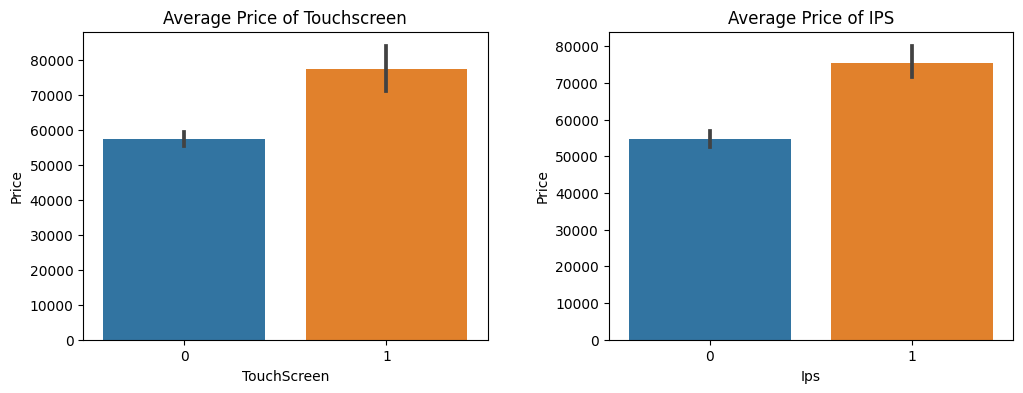

In [19]:
plt.figure(figsize=(12,4)) # defining figure size
plt.subplots_adjust(wspace=0.3) # giving space between plots

# effect of touchscreen and IPS on price
plt.subplot(1,2,1,title='Average Price of Touchscreen')
sns.barplot(x=df['TouchScreen'],y=df['Price']);

plt.subplot(1,2,2,title='Average Price of IPS')
sns.barplot(x=df['Ips'],y=df['Price']);

### Average prices of laptops with Touchscreen and Ips panels are more than those without them.

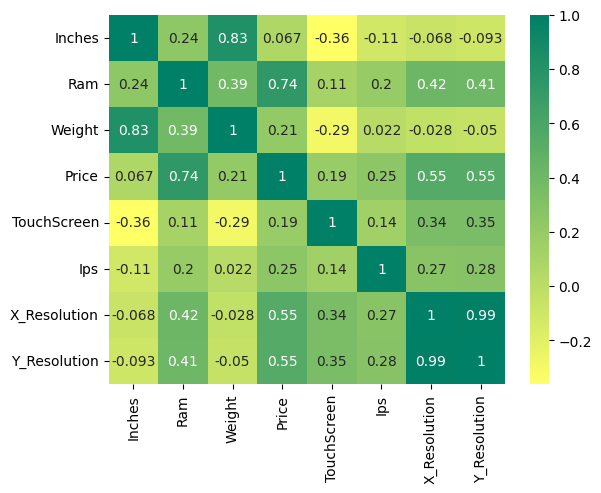

In [20]:
# looking at the correlation of numeric columns
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='summer_r');

### 1. X_res ,Y_res and RAM have strong positive correlation with price.
### 2. Inches has very less correlation with price.
### 3. X_res and Y_res are strongly correlated and weight and inches too.

#### Approach: I will create a new column called PPI (pixel per inch) which will use x_res,y_res and inches and later drop these columns.

In [21]:
# Creating PPI column
df['PPI']=np.sqrt(df["X_Resolution"]**2+df['Y_Resolution']**2)/df["Inches"]

# checking correlation with price
df['PPI'].corr(df['Price'])  # good positive correlation found

0.46953869043441304

In [22]:
# I will now drop irrelevant columns
df.drop(['X_Resolution','Y_Resolution','Inches','ScreenResolution'],inplace=True,axis=1)

In [23]:
df.head()

,Company,TypeName,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,TouchScreen,Ips,PPI
0,Apple,Ultrabook,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,0,1,226.983005
1,Apple,Ultrabook,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,0,0,127.677940
2,HP,Notebook,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000,0,0,141.211998
3,Apple,Ultrabook,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,135195.3360,0,1,220.534624
4,Apple,Ultrabook,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,0,1,226.983005


In [24]:
# Now I will look at the Cpu column
df['Cpu'].value_counts()

Cpu
Intel Core i5 7200U 2.5GHz     190
Intel Core i7 7700HQ 2.8GHz    146
Intel Core i7 7500U 2.7GHz     132
Intel Core i7 8550U 1.8GHz      73
Intel Core i5 8250U 1.6GHz      72
                              ... 
Intel Core M M3-6Y30 0.9GHz      1
AMD A9-Series 9420 2.9GHz        1
Intel Core i5 2.9GHz             1
AMD A6-Series 7310 2GHz          1
AMD A9-Series 9410 2.9GHz        1
Name: count, Length: 118, dtype: int64

### After researching about Cpu column more I found:
##### 1. It contains Processors from AMD and Intel
##### 2. There are 4 categories which I can divide intel processors - i7, i5, i3 and others
##### 3. I will create a column which tells about the processor by breaking down the cpu column into 5 categories: i7, i5, i3, other intel and AMD

In [25]:
# The first three words of the cpu column are enough to give me the info I need
cpu=df["Cpu"].str.split(" ")
df["Cpu_name"]=cpu.map(lambda x : " ".join(x[:3]))

In [26]:
# Making categories from CPU name

def cpu_cat(cpu_name):
    
    """Returns the name of the processor based on previously discussed categories"""
    
    if cpu_name in ["Intel Core i7",'Intel Core i5','Intel Core i3']:
        return cpu_name
    else:
        if cpu_name.split()[0]=='Intel':
            return 'Other Intel Processor'
        else:
            return 'AMD Processor'
        
df["Cpu_name"]=df["Cpu_name"].map(cpu_cat) # changing the column
df.drop('Cpu',inplace=True,axis=1) # dropping the cpu column

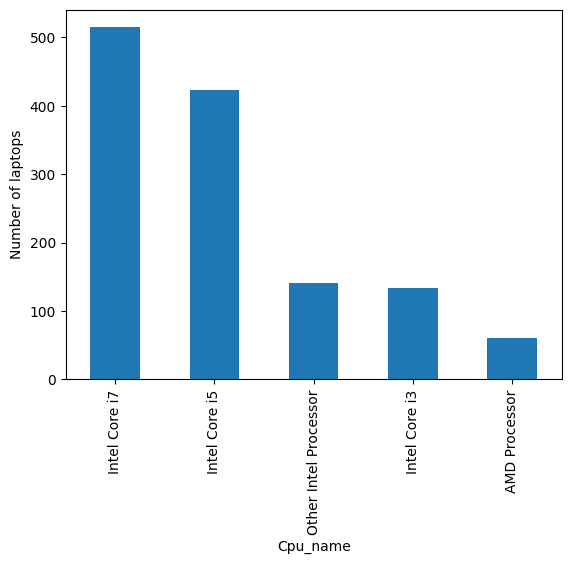

In [27]:
df['Cpu_name'].value_counts().plot(kind='bar') # checking the new categories
plt.ylabel('Number of laptops');

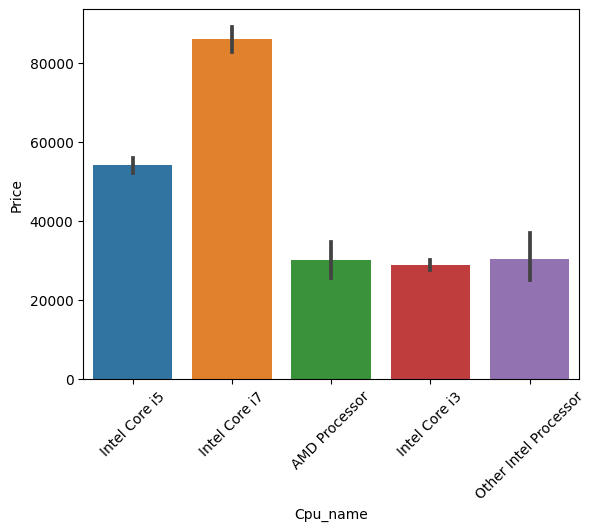

In [28]:
sns.barplot(x=df["Cpu_name"],y=df['Price']);
plt.xticks(rotation=45);

### Cpu clearly affects price. i7 laptops are the most expensive followed by i5 and the others.

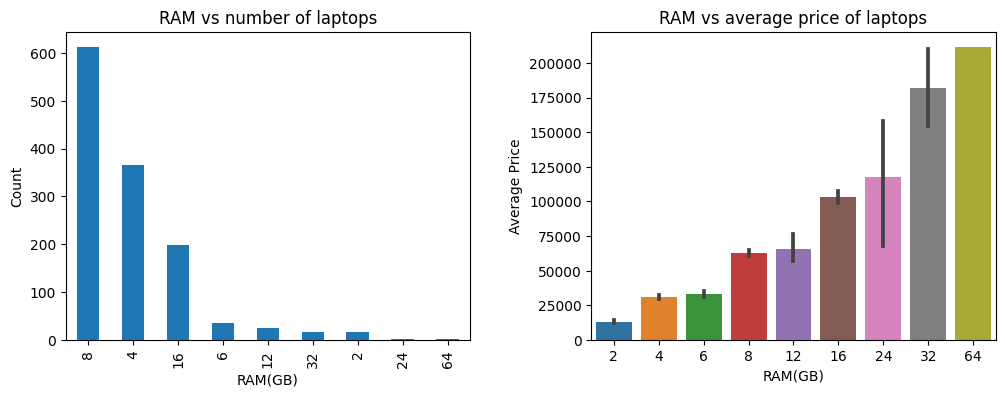

In [29]:
# Looking at Ram column

plt.figure(figsize=(12,4)) # defining figure size
plt.subplots_adjust(wspace=0.3) # giving space between plots

# Number of Laptops of different sizes
plt.subplot(1,2,1,title='RAM vs number of laptops')
df['Ram'].value_counts().plot(kind='bar')
plt.xlabel('RAM(GB)')
plt.ylabel('Count')

# average price of laptops of different sizes
plt.subplot(1,2,2,title='RAM vs average price of laptops')
sns.barplot(x=df['Ram'],y=df['Price'])
plt.xlabel('RAM(GB)')
plt.ylabel('Average Price');

### 1. Most laptops have 8 Gb RAM followed by 4 and 16 GB.
### 2. The price of a Laptop depends strongly on RAM. Also seen from correlation matrix.

In [30]:
# looking at the gpu column
df['Gpu'].value_counts()

Gpu
Intel HD Graphics 620      279
Intel HD Graphics 520      181
Intel UHD Graphics 620      68
Nvidia GeForce GTX 1050     66
Nvidia GeForce GTX 1060     48
                          ... 
AMD Radeon R5 520            1
AMD Radeon R7                1
Intel HD Graphics 540        1
AMD Radeon 540               1
ARM Mali T860 MP4            1
Name: count, Length: 110, dtype: int64

##### 1. After looking at the column I found that there are 4 companies of gpu's.
##### 2. The video memory of GPU is not given.
##### 3. There are too many unique GPU's so I will categorize them based on the company only.

In [31]:
# The first word of he gpu is the company name so I will extract the same
gpu=df['Gpu'].str.split()
df['Gpu_name']=gpu.map(lambda x : x[0])

df['Gpu_name'].value_counts()

Gpu_name
Intel     703
Nvidia    396
AMD       174
ARM         1
Name: count, dtype: int64

### Only one row with GPU ARM. I will drop this row.

In [32]:
df=df[df["Gpu_name"]!="ARM"] # Dropping the row 
df.drop('Gpu',axis=1,inplace=True) # Dropping the Gpu column

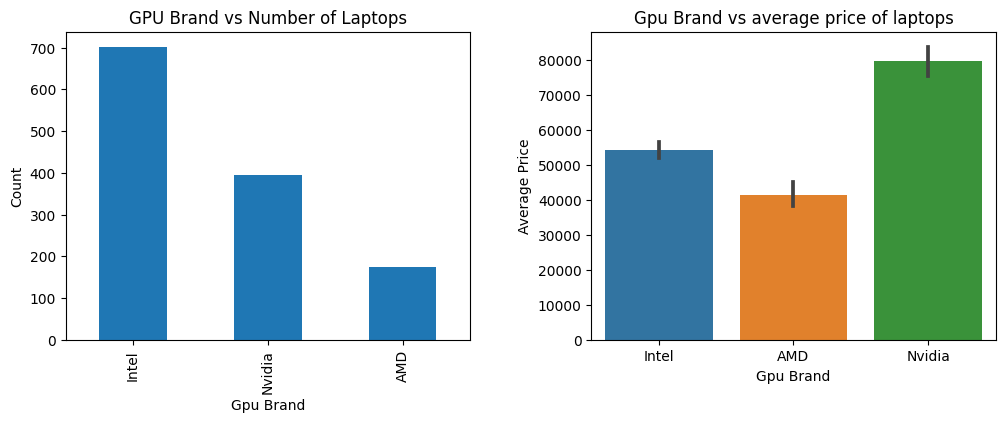

In [33]:
# Looking at Gpu_name column

plt.figure(figsize=(12,4)) # defining figure size
plt.subplots_adjust(wspace=0.3) # giving space between plots

# Number of Laptops of different sizes
plt.subplot(1,2,1,title='GPU Brand vs Number of Laptops')
df['Gpu_name'].value_counts().plot(kind='bar')
plt.xlabel('Gpu Brand')
plt.ylabel('Count')

# average price of laptops of different sizes
plt.subplot(1,2,2,title='Gpu Brand vs average price of laptops')
sns.barplot(x=df['Gpu_name'],y=df['Price'])
plt.xlabel('Gpu Brand')
plt.ylabel('Average Price');

### Nvidia Gpu loaded laptops are the most expensive.
### Most of the laptops have intel GPU's.

## Transforming the memory column

In [34]:
# Looking at the memory column

# Replacing TB with 000
df['Memory']=df["Memory"].str.replace('TB','000')

# some places 1.0 TB was written so it became 1.0000 we will replace it with 1000
df['Memory']=df["Memory"].str.replace('1.0000','1000')

# Replacing GB with ''
df['Memory']=df["Memory"].str.replace('GB','')

# splitting the column values at + sign 
memory=df['Memory'].str.split('+')
memory.head()

0              [128 SSD]
1    [128 Flash Storage]
2              [256 SSD]
3              [512 SSD]
4              [256 SSD]
Name: Memory, dtype: object

### Now I will make 4 columns : SSD HDD FLASH and HYBRID
##### Each column will have the amount of memory the particular laptop holds.
##### For examplpe if a laptop has 1TB SSD + 256GB HDD then the four columns will have these values- SSD:1000,HDD:256,Flash:0,Hybrid:0 

In [35]:
def get_SSD(x):
    """Returns SSD if any in the laptop """
    
    mem=0
    if len(x)==2:
         if 'SSD' in x[1]:
            mem+=int(x[1].split()[0])
                
    if 'SSD' in x[0]:
         mem+=int(x[0].split()[0])
    return mem


def get_HDD(x):
    """Returns HDD if any in the laptop """
        
    mem=0
    if len(x)==2:
         if 'HDD' in x[1]:
            mem+=int(x[1].split()[0])
                
    if 'HDD' in x[0]:
         mem+=int(x[0].split()[0])
    return mem


def get_flash(x):
    """Returns Flash storage if any in the laptop """

    mem=0
    if len(x)==2:
         if 'Flash' in x[1]:
            mem+=int(x[1].split()[0])
                
    if 'Flash' in x[0]:
         mem+=int(x[0].split()[0])
    return mem


def get_hybrid(x):
    """Returns Hybrid Storage if any in the laptop """

    mem=0
    if len(x)==2:
         if 'Hybrid' in x[1]:
            mem+=int(x[1].split()[0])
                
    if 'Hybrid' in x[0]:
         mem+=int(x[0].split()[0])
    return mem

df["HDD"]=memory.map(get_HDD) # making the HDD column
df["SSD"]=memory.map(get_SSD) # making the SSD column
df["Flash"]=memory.map(get_flash) # making the Flash column
df["Hybrid"]=memory.map(get_hybrid) # making the Hybrid column

In [36]:
df.drop('Memory',axis=1,inplace=True)

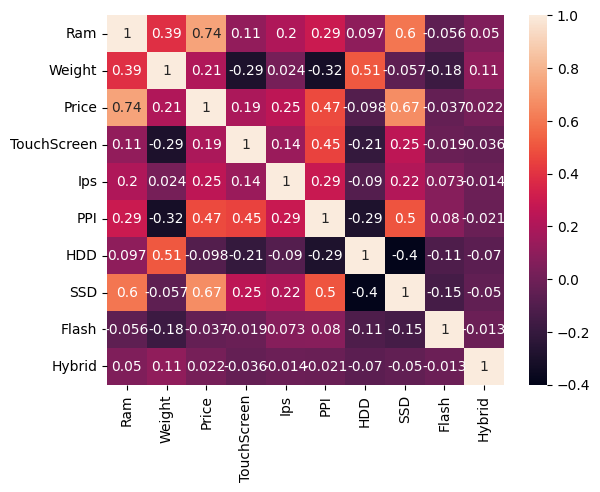

In [37]:
# Looking at correlation matrix of numeric columns again
sns.heatmap(df.corr(numeric_only=True),annot=True);

#### SSD shows strong positive correlation with price.
#### I will drop Hybrid and Flash columns to reduce dimensionalityas they are not affecting price much.

In [38]:
# dropping Flash and Hybrid columns
df.drop(['Flash','Hybrid'],axis=1,inplace=True)

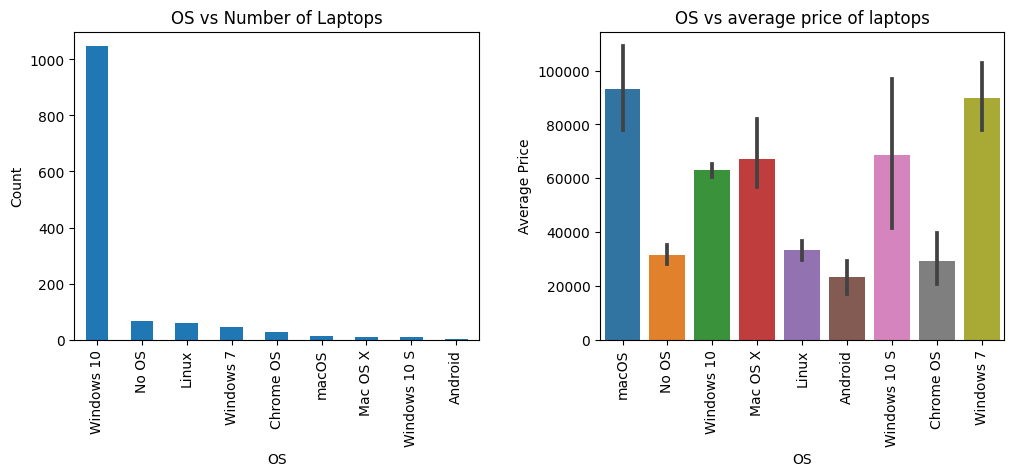

In [39]:
# Only Column left is OpSys

plt.figure(figsize=(12,4)) # defining figure size
plt.subplots_adjust(wspace=0.3) # giving space between plots

# Number of Laptops with different Os
plt.subplot(1,2,1,title='OS vs Number of Laptops')
df['OpSys'].value_counts().plot(kind='bar')
plt.xlabel('OS')
plt.ylabel('Count')

# average price of laptops of different sizes
plt.subplot(1,2,2,title='OS vs average price of laptops')
sns.barplot(x=df['OpSys'],y=df['Price'])
plt.xlabel('OS')
plt.ylabel('Average Price')
plt.xticks(rotation=90);

#### As their are many categories, I will combine them into three main categories with respect to their effect on price.
#### Windows, Mac and Others

In [40]:
def get_os(x):
    if x in ['Windows 10','Windows 7','Windows 10 S']:
        return 'Windows'
    elif x in ['macOS','Mac OS X']:
        return 'Mac'
    else:
        return 'Other'
df['OS']=df['OpSys'].map(get_os)
df.drop('OpSys',axis=1,inplace=True)

In [41]:
# Renaming some columns
df.rename(columns={'Cpu_name':'CPU','Gpu_name':'GPU','Ram':'RAM','Ips':'IPS','TypeName':'Type'},inplace=True)

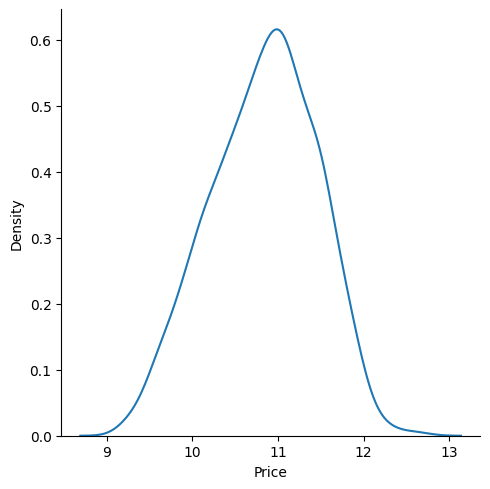

In [42]:
# Transforming the price Column (it had right skewness)

sns.displot(np.log(df['Price']),kind='kde');  # log transformation solved the skewness problem

In [43]:
df['Price']=np.log(df['Price']) # Transforming Price column

In [44]:
X=df.drop('Price',axis=1)  # extracting independent variables
Y=df['Price']  # extracting arget variable

In [45]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.15,random_state=1)

# Model Selection
## Linear Regression

In [46]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[0,1,7,8,11])
],remainder='passthrough')

step2 = LinearRegression()

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,Y_train)

Y_pred = pipe.predict(X_test)

print('R2 score',r2_score(Y_test,Y_pred))
print('MAE',mean_absolute_error(Y_test,Y_pred))

R2 score 0.8331984317405844
MAE 0.1851360097588619


# Decision Tree Regressor

In [47]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[0,1,7,8,11])
],remainder='passthrough')

step2 = DecisionTreeRegressor(max_depth=8)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,Y_train)

Y_pred = pipe.predict(X_test)

print('R2 score',r2_score(Y_test,Y_pred))
print('MAE',mean_absolute_error(Y_test,Y_pred))

R2 score 0.8066317362752817
MAE 0.18705062008908657


## Random Forest Regressor

In [48]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[0,1,7,8,11])
],remainder='passthrough')

step2 = RandomForestRegressor(n_estimators=100,
                              random_state=10,
                              max_samples=0.6,
                              max_features=0.5,
                              max_depth=20)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,Y_train)

Y_pred = pipe.predict(X_test)

print('R2 score',r2_score(Y_test,Y_pred))
print('MAE',mean_absolute_error(Y_test,Y_pred))

R2 score 0.8907133902110675
MAE 0.1468207146621763


### Random Forest Regressor gives the best R2 score

# Exporting the model

In [49]:
pickle.dump(df,open('df.pkl','wb'))
pickle.dump(pipe,open('pipe.pkl','wb'))

In [50]:
X_train.head()

,Company,Type,RAM,Weight,TouchScreen,IPS,PPI,CPU,GPU,HDD,SSD,OS
409,Lenovo,Notebook,2,1.15,0,0,135.094211,Other Intel Processor,Intel,0,0,Windows
94,Asus,Ultrabook,8,1.25,0,0,157.350512,Intel Core i7,Intel,0,256,Windows
579,Dell,Notebook,8,2.20,0,0,141.211998,Intel Core i7,AMD,0,256,Other
386,Lenovo,Notebook,4,1.50,0,1,165.632118,Intel Core i3,Intel,0,128,Windows
936,Dell,Notebook,4,2.18,0,0,100.454670,Intel Core i3,Intel,1000,0,Windows
